# Data analysis 

In this section we restrict our attention to the task periods and deadlines, and we **fix the number of tasks per task set to 2**.

In [1]:
%matplotlib widget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data loading

In [4]:
# Loading data 
df = pd.read_csv("../datasets/new/1k_t4-300000_d_avg1.0-var0.3.csv")

## Observing relationships between variables

Here you can load the dataset you just created in the previous section, by inserting the relative path to the file in the `pd.read_csv()` function.

Alternatively, you can leave the cell as it is and load the dataset already available in the `datasets/new/` folder.

### Comparing the number of minimal constraints with the hyperperiod of a task set

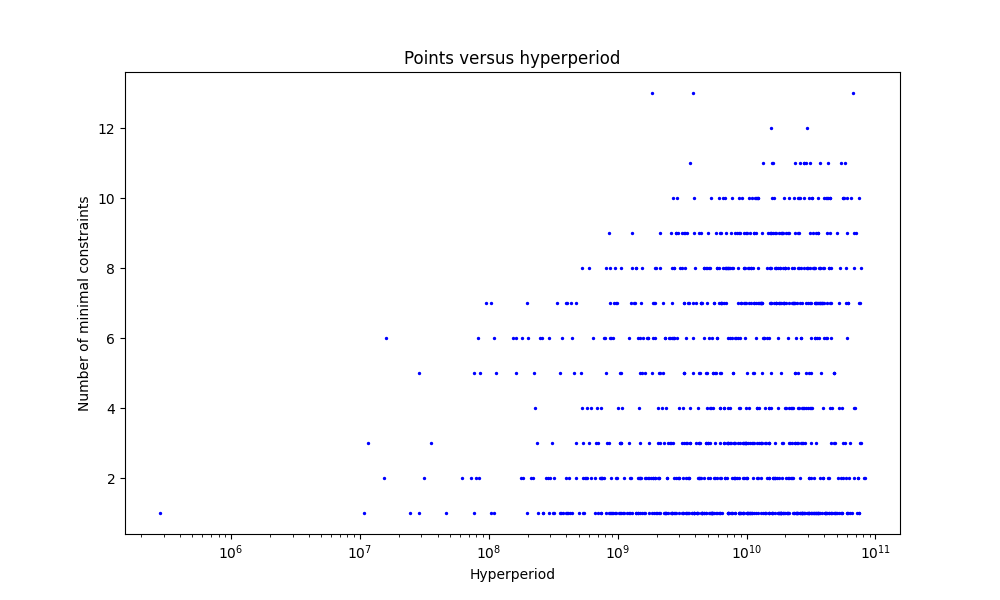

In [6]:

fig, ax = plt.subplots(figsize=(10, 6))


sc = plt.scatter(df['H'], df['m'], c='b', s=2)

ax.set_title('Points versus hyperperiod')
ax.set_xlabel('Hyperperiod')
ax.set_ylabel('Number of minimal constraints')
ax.semilogx() 


annot = ax.annotate("", xy=(0,0), xytext=(10,10),textcoords="offset points",
                        bbox=dict(boxstyle="square", fc="w"),
                        arrowprops=dict(arrowstyle="-",connectionstyle="arc3,rad=0"),
                        annotation_clip=False)
annot.set_visible(False)



def update(ind):
        if len(ind["ind"]) == 1: # Labels become visible if only one point is in the vicinity
                pos = sc.get_offsets()[ind["ind"][0]]
                #print(ind)
                annot.xy = pos
                text = "H={}\nm={}".format(" ".join([str(df['H'][n]) for n in ind["ind"]])," ".join([str(df['m'][n]) for n in ind["ind"]]))
                annot.set_text(text)
                annot.get_bbox_patch().set_facecolor('white')
                annot.get_bbox_patch().set_alpha(1.0)
                bbox=dict(boxstyle="square", fc="w")

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()



On the above plot you can hover over the points to see the values of the hyperperiod ($H$) and the number $m$ of minimal constraints. The labels won't appear unless the cursor is near exactly one point. 

### Deadline-Period ratios in a 2-task-system vs the `m` value

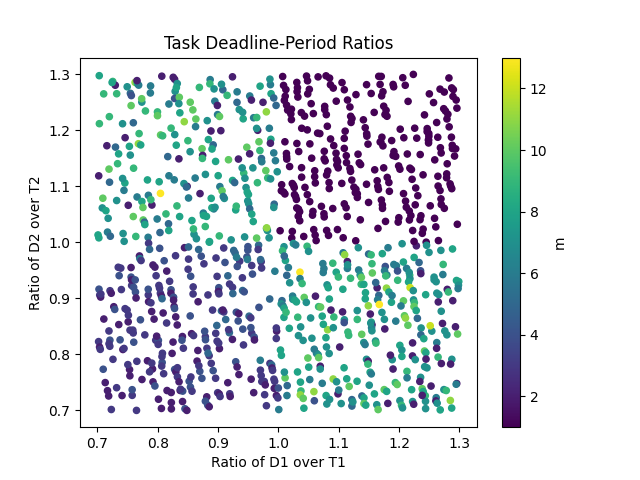

In [7]:
fig = df.plot(kind = 'scatter',
        title = 'Task Deadline-Period Ratios',
        x = 'Ratio1', 
        y = 'Ratio2',
        xlabel= 'Ratio of D1 over T1',
        ylabel= 'Ratio of D2 over T2',
        c = 'm',
        colormap='viridis')
plt.show()

From the above plot it can be observed that higher values of `m` are associated with a situation where one task's ratio is greater than 1 and the other task's ratio is less than 1 (the two light-colored areas in the plot).
Taking this into account, we add a categorical feature to the dataframe, which indicates whether the task set falls in one of the two light-colored areas or not.

In [8]:
# Add a column named 'DiscRatios' that is 1 if one of the ratios is greater than 1 and the other is less than 1, otherwise is 0
condition = [(df['Ratio1'] > 1) & (df['Ratio2'] < 1)]
df1 = df.assign(DiscRatios = np.select(condition, [1], default = 0))

We can now re-plot the above scatter plot, but this time coloring the points according to the new categorical feature.

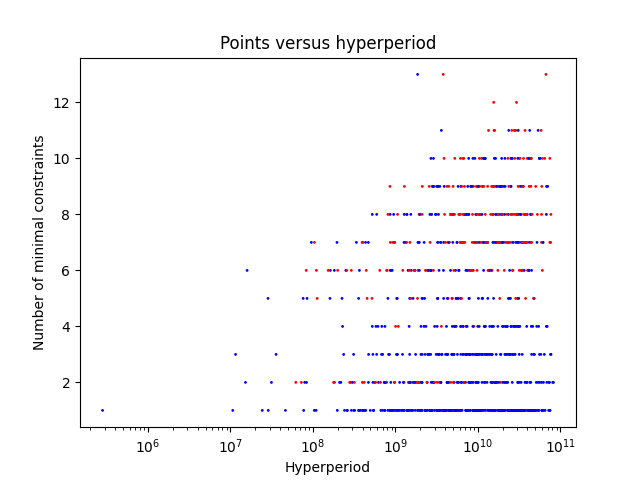

In [9]:
fig,ax = plt.subplots()

colors = {0:'blue', 1:'red'}

ax.scatter(df1['H'], df1['m'], c = df1['DiscRatios'].map(colors),marker='.',s=4)

ax.set_title('Points versus hyperperiod')
ax.set_xlabel('Hyperperiod')
ax.set_ylabel('Number of minimal constraints')
ax.set_xscale('log')
plt.show()

## Visualize the convex hull of minimal constraints (in 2-task systems)

The following section is **valid only for 2-task systems**. 

Since we can represent each constraint in the EDF schedulability test as a vector (with as many components as number of tasks), the convex hull of the minimal set of constraints in a 2-task system is representable in a 2-dimensional space. 

To do so, we import the class [ConvexHull](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html#scipy.spatial.ConvexHull) from the  (**[SciPy](https://docs.scipy.org)** library) to compute the convex hull given as input the already minimal set of constraints.  

In [10]:
from scipy.spatial import ConvexHull

You can observe that the convex hull is a polygon with a number of vertices equal to the number of constraints in the minimal set.

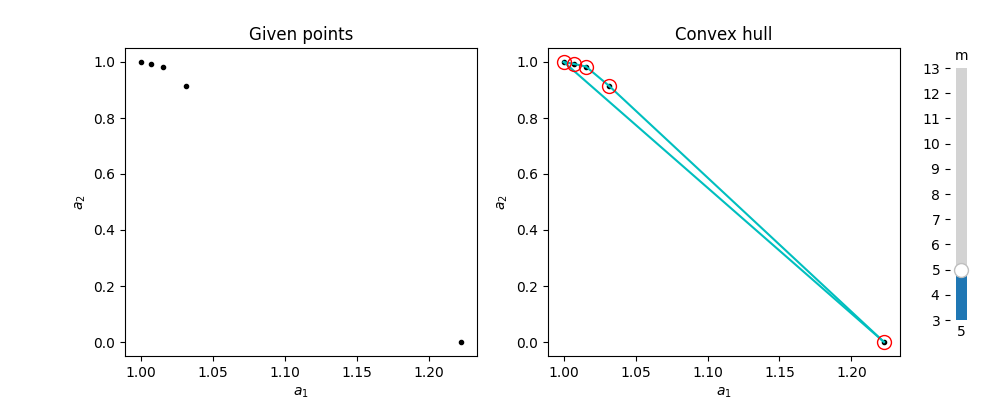

Clicked on point: 
 Seed                      617
T1                      30660
D1               25384.633236
Ratio1                0.82794
T2                     104370
D2              134752.591381
Ratio2               1.291105
H                    15238020
m                           2
Original_m                649
Percentage_m         0.006144
Name: 1, dtype: object 



In [11]:
from matplotlib.widgets import Slider

# Global variable to store input points and keep them accessible to update() and onpick() functions
global points

# Global variable to store the picked points' indexes
# global ind_picked_points

# Parametrized function that retrieves a_1 and a_2 for all m constraints found in the minimal set  
def input_points(m):
    data = pd.read_csv("../datasets/additional_info/n-2_m-" + str(m) + ".csv")

    # Input is 2D array with a_1 and a_2 components
    a_1 = np.array(data['a_1'])
    a_2 = np.array(data['a_2'])
    points =  np.array([a_1, a_2]).T
    return points

# Update function for sliders
def update(val):
    global points 
    points= input_points(m_slider.val)

    for ax in (ax1, ax2):
        ax.clear()
        ax.set_xlabel('a_1')
        ax.set_ylabel('a_2')
        ax.plot(points[:, 0], points[:, 1], '.', color='k', picker=5)
        if ax == ax1:
            ax.set_title('Given points')
        else:
            ax.set_title('Convex hull')
            hull = ConvexHull(points, incremental=False, qhull_options='Fx')

            # Draw convex hull
            for simplex in hull.simplices:
                ax.plot(points[simplex, 0], points[simplex, 1], 'c')

            ax.plot(points[hull.vertices, 0], points[hull.vertices, 1], 'o', mec='r', color='none', lw=1, markersize=10)
            #print("With ",val," initial constraints the resulting convex hull has ", len(hull.vertices)," vertices").
        fig.canvas.draw_idle()
       


# Function to print picked points' information
def onpick(event):
    ind = event.ind

    # Print picked point's information
    print("Clicked on point: \n",selected_list.iloc[ind[0], :-1], "\n")
    
    # Add picked point's index to global array containing all picked points' indexes
    #global ind_picked_points
    #ind_picked_points = np.append(ind_picked_points, ind[0])

# Define initial m value
init_m = 5

# Get constraints' coordinates for initial m
points = input_points(init_m)

# Create figure and the two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
for ax in (ax1, ax2):

    # Plot just points on left subplot
    ax.plot(points[:, 0], points[:, 1], '.', color='k',picker=5)

    ax.set_xlabel('$a_1$')
    ax.set_ylabel('$a_2$')
    if ax == ax1:
        ax.set_title('Given points')
    else:
        ax.set_title('Convex hull')
        hull = ConvexHull(points, incremental=False, qhull_options='Fx')
        # Draw convex hull
        for simplex in hull.simplices:
            ax.plot(points[simplex, 0], points[simplex, 1], 'c')

        ax.plot(points[hull.vertices, 0], points[hull.vertices, 1], 'o', mec='r', color='none', lw=1, markersize=10)

# Set function to be called when a point is clicked
fig.canvas.mpl_connect('pick_event', onpick)

# All m values available in selected_list
selected_list = pd.read_csv('../datasets/selected.csv')
m_values = selected_list['m'].unique()

# Minimum m value must be greater or equal 3 (otherwise graph degenerates)
min_allowed = lambda m_values: 3 if min(m_values) < 3 else min(m_values) 

# Slider to select m value
ax_sl=plt.axes([0.95, 0.20, 0.0225, 0.63])
m_slider = Slider(ax_sl, label='m', valmin=min_allowed(m_values), valmax= max(m_values), valinit=init_m, valstep=1,orientation='vertical')

# Add ticks to slider
ax_sl.add_artist(ax_sl.yaxis)
sl_yticks = np.arange(min_allowed(m_values),max(m_values)+1,1)
ax_sl.set_yticks(sl_yticks)



# Call update function when slider changes
m_slider.on_changed(update)

# Show plot
plt.show()


### Interactive plot

The above plot is interactive: 
* You can **switch task set analyzed** by using the slider on the right: the `m` value is unique for each task set in the `selected` dataset.
* You can click on the **vertices** of the convex hull to **highlight the corresponding coordinates** in the plot above.

A note: when picking the vertices of the convex hull, it can happen that more than one point is selected at the same time. This is due to the fact that the points are very close to each other and the click is not precise enough. In this case, try zooming in with the rectangle tool in the top left corner of the figure and try again.

When you are done, don't forget to run the following cell to free the memory.

In [12]:
plt.close('all')